# **Regressão Linear Multivariada com Intervalos de Confiança**

## Carregamento e Pré-processamento dos Dados

### Carregamento do Dataset

In [288]:
# Importação das bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [289]:
# Carregamento do dataset
us_change = pd.read_csv("data/us_change.csv")
display(us_change)  # Exibe as primeiras linhas do dataset

,Quarter,Consumption,Income,Production,Savings,Unemployment
0,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
1,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
2,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
3,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
4,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
193,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
194,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
195,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
196,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


## Funções auxiliares

### Modelagem

In [290]:
class LinearRegression():
    def fit(self, X, y):
        X = np.c_[np.ones(X.shape[0]), X.values]
        self.X_train = X
        self.y_train = y.values
        self.coefficients = np.linalg.pinv(X.T @ X) @ X.T @ y.values
        residuals = y.values - X @ self.coefficients
        self.sigma_squared = np.sum(residuals**2) / (X.shape[0] - X.shape[1])
        self.X_inv = np.linalg.pinv(X.T @ X)

    def predict(self, X, confidence_interval=False):
        X = np.c_[np.ones(X.shape[0]), X.values]
        y_pred = X @ self.coefficients

        if confidence_interval:
            variance_predictions = np.array([
                self.sigma_squared * (1 + X_i @ self.X_inv @ X_i.T) for X_i in X
            ])
            t_value = stats.t.ppf(1 - 0.025, df=self.X_train.shape[0] - self.X_train.shape[1])
            margin_of_error = t_value * np.sqrt(variance_predictions)
            lower_bound = y_pred - margin_of_error
            upper_bound = y_pred + margin_of_error
            return y_pred, lower_bound, upper_bound

        return y_pred

    def num_coef(self):
        return len(self.coefficients)

### Funções de Avaliação e Visualização

In [291]:
# Métricas de Avaliação
def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def calculate_rmse(mse):
    return np.sqrt(mse)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def calculate_aic(y_true, y_pred, n, k):
    residual_sum_of_squares = np.sum((y_true - y_pred) ** 2)
    return n * np.log(residual_sum_of_squares / n) + 2 * k

def calculate_bic(y_true, y_pred, n, k):
    residual_sum_of_squares = np.sum((y_true - y_pred) ** 2)
    return n * np.log(residual_sum_of_squares / n) + k * np.log(n)

# Função para realizar o Teste de Ljung-Box
def perform_ljung_box_test(residuals, lags=[10]):
    """
    Realiza o teste de Ljung-Box nos resíduos e exibe os resultados.
    """
    ljung_box_results = acorr_ljungbox(residuals, lags=lags, return_df=True)
    print("\nTeste de Ljung-Box:")
    print(ljung_box_results)

# Visualizações
def plot_predictions(us_change, y_train, y_forecast, y_pred, y_pred_lower_bound, y_pred_upper, title="Série Temporal: Treinamento, Previsão Real e Previsão do Modelo"):
    plt.figure(figsize=(10, 6))
    plt.plot(us_change['IndexQuarter'][:len(y_train)], y_train, label='Treinamento', color='black')
    plt.plot(us_change['IndexQuarter'][len(y_train):len(y_train) + len(y_forecast)], y_forecast, label='Previsão Real', color='blue')
    plt.plot(us_change['IndexQuarter'][len(y_train):len(y_train) + len(y_pred)], y_pred, label='Previsão Modelo', color='red')
    plt.fill_between(us_change['IndexQuarter'][len(y_train):len(y_train) + len(y_pred)], y_pred_lower_bound, y_pred_upper, color='red', alpha=0.2)
    plt.title(title)
    plt.xlabel('Trimestre')
    plt.ylabel('% de Mudança no Consumo')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

def _plot_residuals(y_real, y_pred, title="Resíduos vs Valores Ajustados"):
    residuals = y_real - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--", linewidth=1)
    plt.title(title)
    plt.xlabel("Valores Ajustados")
    plt.ylabel("Resíduos")
    plt.show()

def plot_residuals(y_true, y_pred, y_train, y_pred_train):
    # Plot residuos no treinamento
    _plot_residuals(y_train, y_pred_train, title="Resíduos no Treinamento")
    
    # Plot residuos no forecast
    _plot_residuals(y_true, y_pred, title="Resíduos no Forecast")
    
def print_metrics(y_true, y_pred, num_coef):
    mae = calculate_mae(y_true, y_pred)
    mse = calculate_mse(y_true, y_pred)
    rmse = calculate_rmse(mse)
    mape = calculate_mape(y_true, y_pred)
    r2 = calculate_r2(y_true, y_pred)
    
    n = len(y_true)
    k = num_coef
    
    aic = calculate_aic(y_true, y_pred, n, k)
    bic = calculate_bic(y_true, y_pred, n, k)
    
    print(f"\nMAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}%")
    print(f"R²: {r2}")
    print(f"AIC: {aic}")
    print(f"BIC: {bic}")
    
    perform_ljung_box_test(y_true - y_pred)
    
def display_and_plot_coefficients(model, X_train, title="Coeficientes Estimados"):
    
    # Organizando os coeficientes do modelo em um DataFrame
    coefficients = pd.DataFrame({
        'Variável': ['Intercepto'] + list(X_train.columns),
        'Coeficiente': model.coefficients
    })

    # Plotando os coeficientes (exceto o intercepto)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=coefficients[1:], x='Coeficiente', y='Variável', orient='h', palette='viridis')
    plt.title(title)
    plt.xlabel('Valor do Coeficiente')
    plt.ylabel('Variável')
    plt.axvline(0, color='red', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()
    
    display(coefficients)

def display_correlation_matrix(X_train, y_train, target_name='Consumption', title="Matriz de Correlação: Covariáveis e Target"):
    # Criando uma cópia do conjunto de treinamento e adicionando o target
    X_train_with_target = X_train.copy()
    X_train_with_target[target_name] = y_train

    # Calculando a matriz de correlação
    correlation_matrix = X_train_with_target.corr()

    # Plotando a matriz de correlação
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    ax.set_title(title)
    
    plt.show()
    
    display(correlation_matrix)


## Pré-processamento e Divisão dos Dados

In [292]:
# Criação da coluna 'IndexQuarter' para numerar os trimestres
us_change['IndexQuarter'] = np.arange(len(us_change))

In [293]:
# Criando colunas de sazonalidade com base no último caractere de Quarter (Q1, Q2, Q3, Q4)
us_change['Quarter'] = us_change['Quarter'].astype(str)  # Certificar que Quarter seja string
us_change['Season'] = us_change['Quarter'].str[-2:]  # Extraindo os últimos dois caracteres (Q1, Q2, etc.)

# Gerando colunas dummy para os trimestres
seasonal_dummies = pd.get_dummies(us_change['Season'], prefix='Quarter', drop_first=True, dtype=int)

# Adicionando as colunas de sazonalidade ao dataset
us_change = pd.concat([us_change, seasonal_dummies], axis=1)

# Removendo a coluna 'Season', já que agora temos as dummies
us_change = us_change.drop(columns=['Season'])

In [294]:
us_change = us_change.drop(columns=['Quarter'])  # Removendo a coluna 'Quarter' não necessária

In [295]:
# Definindo a fração para forecast e dividindo os dados em treino e forecast
forecast_steps = 20
forecast_fraction = forecast_steps / len(us_change)

X = us_change.drop(columns='Consumption')
y = us_change['Consumption']

## Modelo Inicial: Regressão Linear Multivariada

### Treinamento e Previsões

In [296]:
X_simplificado = us_change[['Income', 'Production', 'Savings', 'Unemployment', 'IndexQuarter']]
print(f"Covariaveis: {list(X_simplificado.columns)}")
X_train, X_forecast, y_train, y_forecast = train_test_split(X_simplificado, y, test_size=forecast_fraction, shuffle=False)

# Ajustando o modelo simplificado
model_simple = LinearRegression()
model_simple.fit(X_train, y_train)

# Previsões
y_pred_simple, lower_simple, upper_simple = model_simple.predict(X_forecast, confidence_interval=True)

y_pred_simple

Covariaveis: ['Income', 'Production', 'Savings', 'Unemployment', 'IndexQuarter']


array([0.9750391 , 1.1348126 , 0.80837506, 0.6778234 , 0.75178675,
       0.4441034 , 0.63923878, 0.58261757, 0.59191336, 0.681055  ,
       0.59877435, 0.67830263, 0.57743117, 0.97541496, 0.51305629,
       0.81922441, 0.86588226, 0.38555843, 0.45871743, 0.81239933])

### Avaliação e resultados

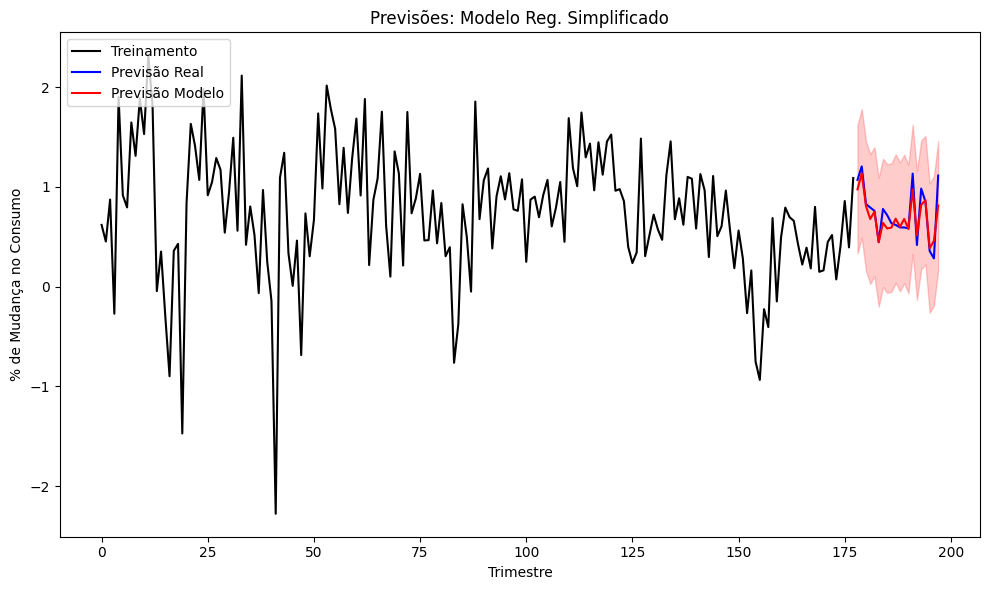

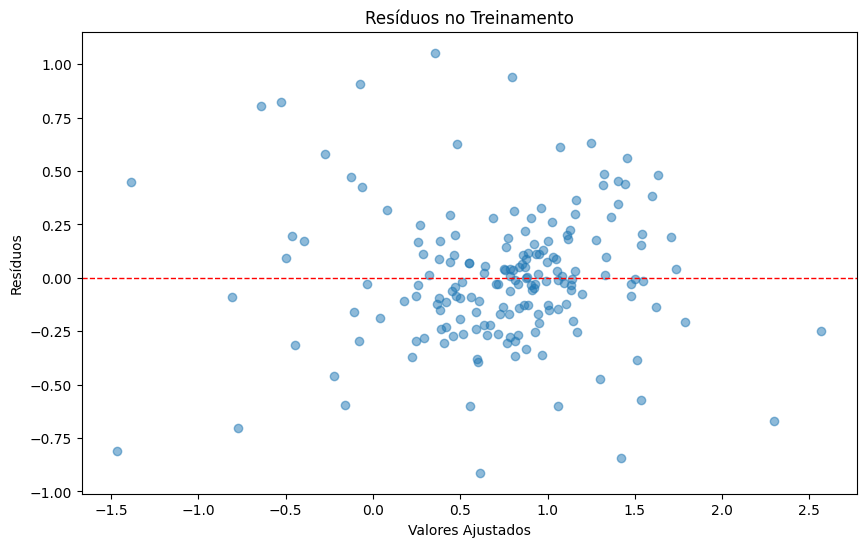

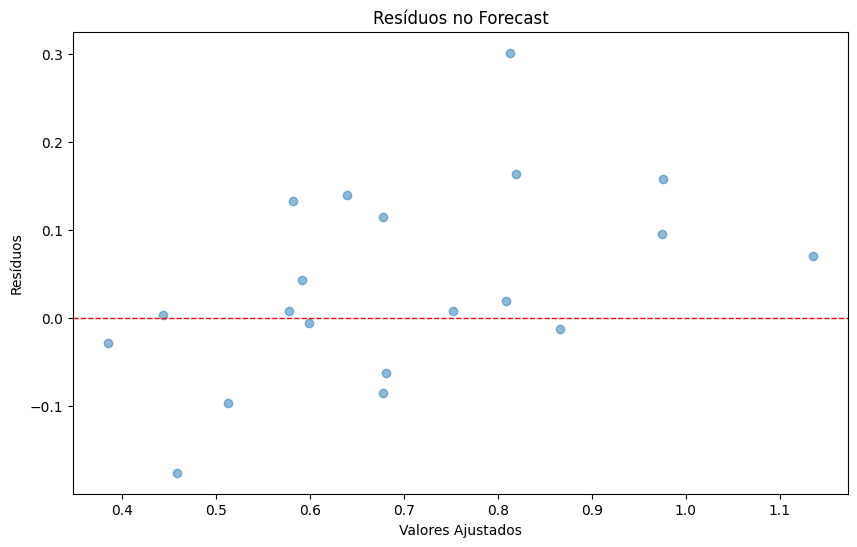


MAE: 0.08609518927325614
MSE: 0.013068291280428395
RMSE: 0.11431662731391438
MAPE: 12.773765758059803%
R²: 0.8054962666323641
AIC: -74.75132991793302
BIC: -68.77693627660908

Teste de Ljung-Box:
     lb_stat  lb_pvalue
10  8.446062   0.585352


C:\Users\almir\AppData\Local\Temp\ipykernel_13100\3384250196.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coefficients[1:], x='Coeficiente', y='Variável', orient='h', palette='viridis')


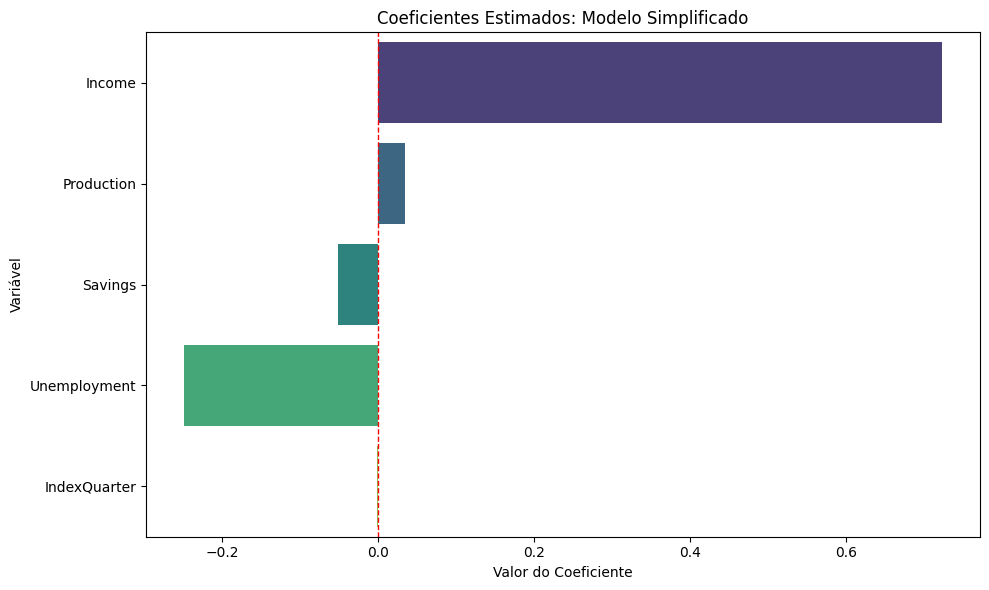

,Variável,Coeficiente
0,Intercepto,0.376158
1,Income,0.722701
2,Production,0.034545
3,Savings,-0.051569
4,Unemployment,-0.248726
5,IndexQuarter,-0.001110


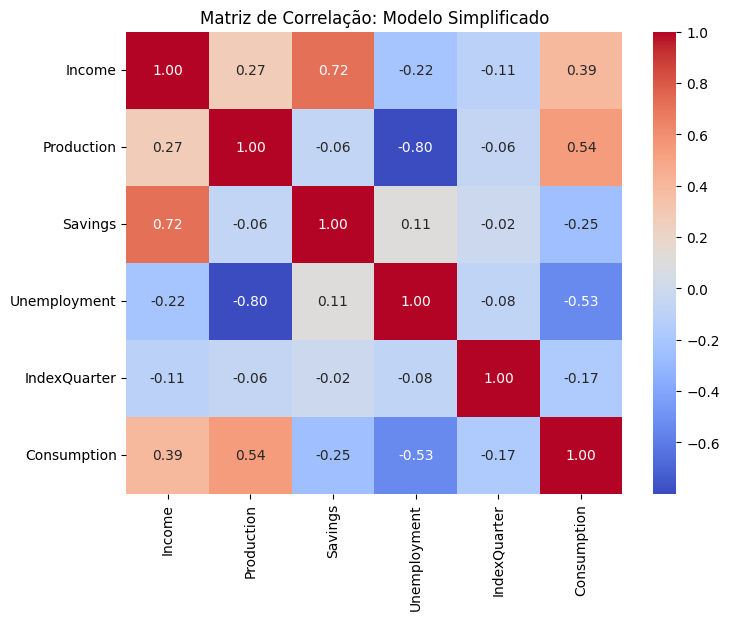

,Income,Production,Savings,Unemployment,IndexQuarter,Consumption
Income,1.000000,0.271602,0.717986,-0.220890,-0.107296,0.389311
Production,0.271602,1.000000,-0.063803,-0.799395,-0.055040,0.538513
Savings,0.717986,-0.063803,1.000000,0.111255,-0.017834,-0.252514
Unemployment,-0.220890,-0.799395,0.111255,1.000000,-0.082061,-0.533097
IndexQuarter,-0.107296,-0.055040,-0.017834,-0.082061,1.000000,-0.170683
Consumption,0.389311,0.538513,-0.252514,-0.533097,-0.170683,1.000000


In [297]:
# Visualizando as Previsões
plot_predictions(us_change, y_train, y_forecast, y_pred_simple, lower_simple, upper_simple, title="Previsões: Modelo Reg. Simplificado")

# Visualizando Resíduos
plot_residuals(y_forecast, y_pred_simple, y_train, model_simple.predict(X_train))

# Calculando Métricas
print_metrics(y_forecast, y_pred_simple, model_simple.num_coef())

# Exibindo os coeficientes
display_and_plot_coefficients(model_simple, X_train, title="Coeficientes Estimados: Modelo Simplificado")

# Exibindo a matriz de correlação
display_correlation_matrix(X_train, y_train, title="Matriz de Correlação: Modelo Simplificado")

## Modelo Sazonal: Regressão Linear Multivariada com Dummies Sazonais

In [298]:
print(f"Covariaveis: {list(X.columns)}")
X_train, X_forecast, y_train, y_forecast = train_test_split(X, y, test_size=forecast_fraction, shuffle=False)

# Ajustando o modelo com dummies sazonais
model_seasonal = LinearRegression()
model_seasonal.fit(X_train, y_train)

# Previsões
y_pred_seasonal, lower_seasonal, upper_seasonal = model_seasonal.predict(X_forecast, confidence_interval=True)

Covariaveis: ['Income', 'Production', 'Savings', 'Unemployment', 'IndexQuarter', 'Quarter_Q2', 'Quarter_Q3', 'Quarter_Q4']


### Avaliação e resultados

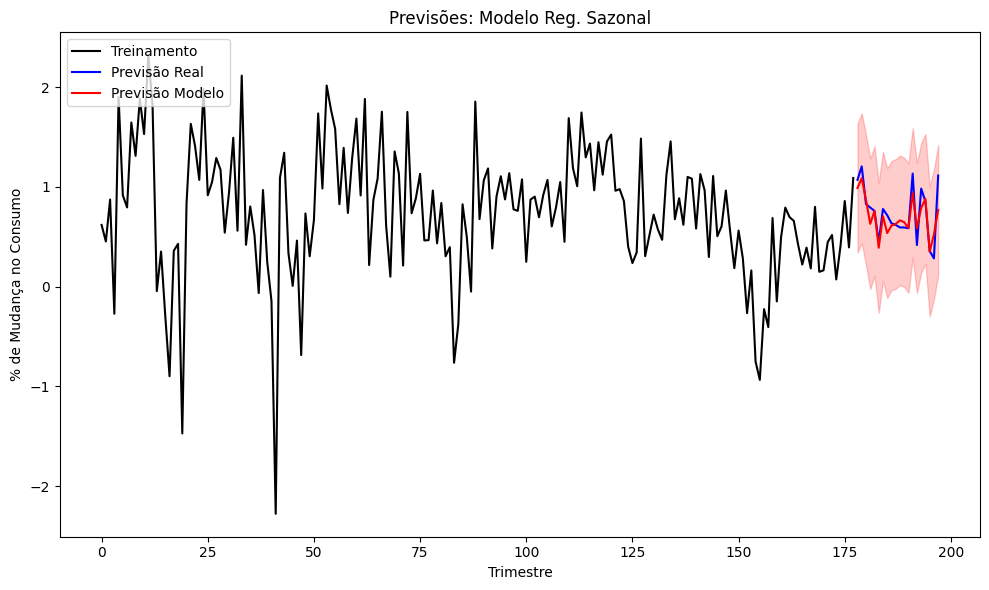

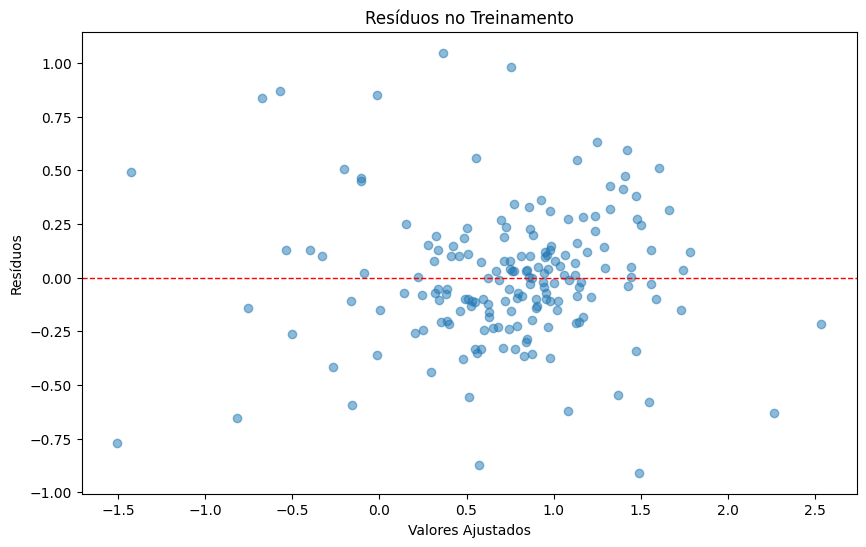

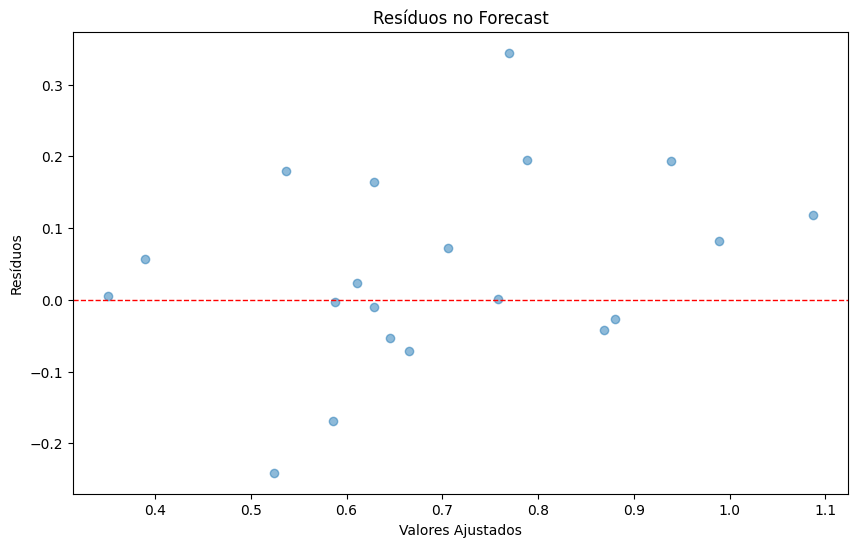


MAE: 0.1026178316167412
MSE: 0.018986291367138686
RMSE: 0.13779075211036002
MAPE: 15.775921303704479%
R²: 0.7174148881082231
AIC: -61.28076134439668
BIC: -52.31917088241076

Teste de Ljung-Box:
      lb_stat  lb_pvalue
10  15.943399   0.101264


C:\Users\almir\AppData\Local\Temp\ipykernel_13100\3384250196.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coefficients[1:], x='Coeficiente', y='Variável', orient='h', palette='viridis')


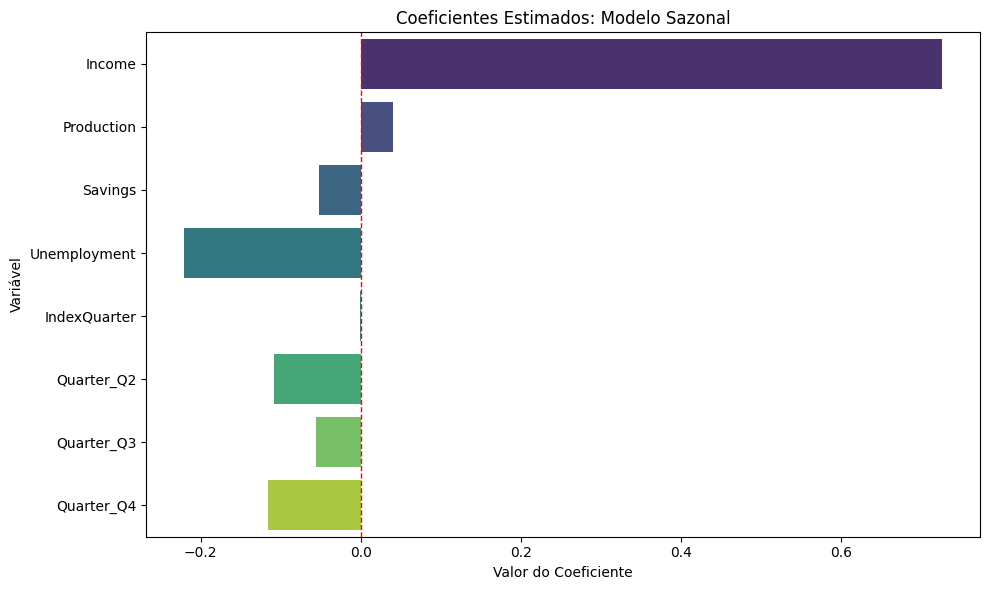

,Variável,Coeficiente
0,Intercepto,0.435957
1,Income,0.726307
2,Production,0.040524
3,Savings,-0.051679
4,Unemployment,-0.221112
5,IndexQuarter,-0.001069
6,Quarter_Q2,-0.107814
7,Quarter_Q3,-0.055594
8,Quarter_Q4,-0.115536


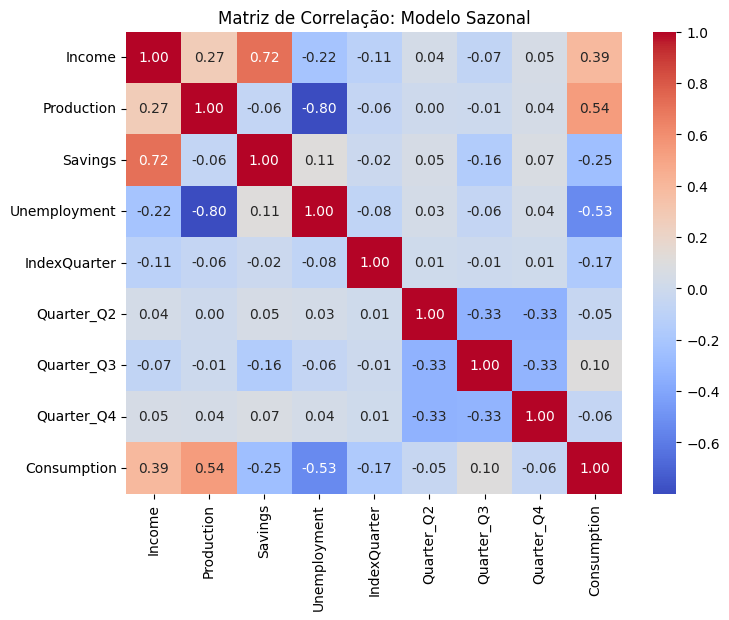

,Income,Production,Savings,Unemployment,IndexQuarter,Quarter_Q2,Quarter_Q3,Quarter_Q4,Consumption
Income,1.000000,0.271602,0.717986,-0.220890,-0.107296,0.035663,-0.069155,0.047774,0.389311
Production,0.271602,1.000000,-0.063803,-0.799395,-0.055040,0.000757,-0.009535,0.041161,0.538513
Savings,0.717986,-0.063803,1.000000,0.111255,-0.017834,0.045177,-0.158977,0.065967,-0.252514
Unemployment,-0.220890,-0.799395,0.111255,1.000000,-0.082061,0.031956,-0.056103,0.036110,-0.533097
IndexQuarter,-0.107296,-0.055040,-0.017834,-0.082061,1.000000,0.005660,-0.005576,0.005576,-0.170683
Quarter_Q2,0.035663,0.000757,0.045177,0.031956,0.005660,1.000000,-0.333315,-0.333315,-0.045035
Quarter_Q3,-0.069155,-0.009535,-0.158977,-0.056103,-0.005576,-0.333315,1.000000,-0.328358,0.101549
Quarter_Q4,0.047774,0.041161,0.065967,0.036110,0.005576,-0.333315,-0.328358,1.000000,-0.055540
Consumption,0.389311,0.538513,-0.252514,-0.533097,-0.170683,-0.045035,0.101549,-0.055540,1.000000


In [299]:
# Visualizando as Previsões
plot_predictions(us_change, y_train, y_forecast, y_pred_seasonal, lower_seasonal, upper_seasonal, title="Previsões: Modelo Reg. Sazonal")

# Visualizando Resíduos
plot_residuals(y_forecast, y_pred_seasonal, y_train, model_seasonal.predict(X_train))

# Calculando Métricas
print_metrics(y_forecast, y_pred_seasonal, model_seasonal.num_coef())

# Exibindo os coeficientes
display_and_plot_coefficients(model_seasonal, X_train, title="Coeficientes Estimados: Modelo Sazonal")

# Exibindo a matriz de correlação
display_correlation_matrix(X_train, y_train, title="Matriz de Correlação: Modelo Sazonal")

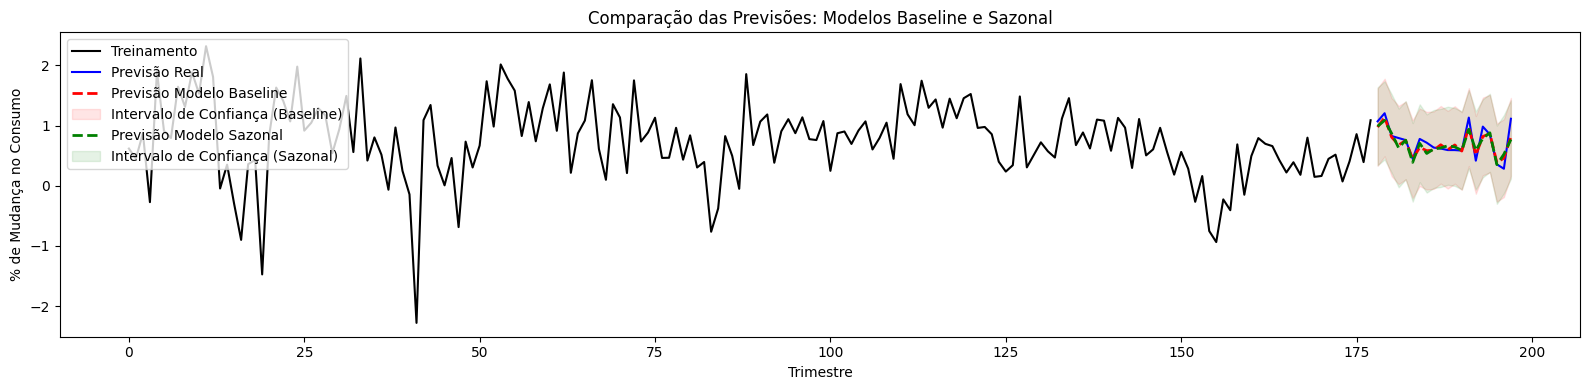

In [300]:
# %% [markdown]
# ### Visualização Comparativa das Previsões: Modelos Baseline e Sazonal

# %%
plt.figure(figsize=(16, 4))

# Conjunto de treino
plt.plot(us_change['IndexQuarter'][:len(y_train)], y_train, label='Treinamento', color='black', linewidth=1.5)

# Valores reais de previsão
plt.plot(us_change['IndexQuarter'][len(y_train):len(y_train) + len(y_forecast)], y_forecast, label='Previsão Real', color='blue', linewidth=1.5)

# Previsões do modelo baseline
plt.plot(us_change['IndexQuarter'][len(y_train):len(y_train) + len(y_pred_simple)], y_pred_simple, label='Previsão Modelo Baseline', color='red', linestyle='--', linewidth=2)
plt.fill_between(
    us_change['IndexQuarter'][len(y_train):len(y_train) + len(y_pred_simple)], 
    lower_simple, 
    upper_simple, 
    color='red', 
    alpha=0.1, 
    label='Intervalo de Confiança (Baseline)'
)

# Previsões do modelo sazonal
plt.plot(us_change['IndexQuarter'][len(y_train):len(y_train) + len(y_pred_seasonal)], y_pred_seasonal, label='Previsão Modelo Sazonal', color='green', linestyle='--', linewidth=2)
plt.fill_between(
    us_change['IndexQuarter'][len(y_train):len(y_train) + len(y_pred_seasonal)], 
    lower_seasonal, 
    upper_seasonal, 
    color='green', 
    alpha=0.1, 
    label='Intervalo de Confiança (Sazonal)'
)

# Títulos e legendas
plt.title('Comparação das Previsões: Modelos Baseline e Sazonal')
plt.xlabel('Trimestre')
plt.ylabel('% de Mudança no Consumo')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
